# **Supervised Learning**

---

This notebook implements the full supervised learning pipeline for the **HCC1806 cell line**. The aim is to build high-performance binary classifiers that predict the oxygenation condition (normoxia vs hypoxia) of each cell based on gene expression.


For each combination of cell line and technology, we:

- Align metadata and create binary labels from the known condition
- Standardize the expression values (scaling)
- Perform different feature selection strategies tailored to each technology and compare model performance
- Save the best models for test prediction

> We now work with the instructor-provided **filtered and normalized training datasets**. 

> Each step is repeated for both **Smart-seq** and **Drop-seq** datasets, maintaining the same methodology for consistent comparison and integration.

## Index

1. [Load Datasets](#1-load-datasets)  
2. [Align Labels](#2-align-labels)
3. [Preprocessing](#3-preprocessing) 
4. [Feature Selection](#4-feature-selection)  
   - [4.1 SmartSeq](#41-smartseq)
      - [4.1.1 Elastic Net Logistic Regression](#411-elastic-net-logistic-regression)  
      - [4.1.2 Random Forest Importance](#412-random-forest-importance)  
      - [4.1.3 Stability Across Seeds](#413-stability-across-seeds)
   - [4.2 DropSeq](#42-dropseq)
      - [4.2.1 Elastic Net Logistic Regression](#421-elastic-net-logistic-regression) 
      - [4.2.2 Random Forest Importance](#422-random-forest-importance)  
      - [4.2.3 Stability Across Seeds](#423-stability-across-seeds)
5. [Biological Enrichment](#5-biological-enrichment)
   - [5.1 SmartSeq](#51-smartseq)
      - [5.1.1 Over-Representation Analysis (ORA)](#511-over---representation-analysis-ora)
      - [5.1.2 Comparison with Buffa's signature](#512-comparison-with-Buffas-signature)
      - [5.1.3 Expression Patterns of Top Stable Genes](#513-expression-patterns-of-top-stable-genes)
   - [5.2 DropSeq](#52-dropseq)
      - [5.2.1 Over-Representation Analysis](#521-over---representation-analysis)
      - [5.2.2 Comparison with Buffa's signature](#522-comparison-with-Buffas-signature)
      - [5.2.3 Expression Patterns of Top Stable Genes](#523-expression-patterns-of-top-stable-genes)
6. [Model Training and Evaluation](#6-model-training-and-evaluation) 


In [1]:
import os
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pickle
import joblib
from scipy.stats import skew, kurtosis, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import gseapy as gp
from gseapy.plot import barplot, dotplot
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve)
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from collections import Counter
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from matplotlib_venn import venn2
from pathlib import Path

## **1.** Load Datasets

---

### ***SmartSeq***

We are going to transpose the dataset so that it matches sklearn’s expected input format (n_samples × n_features).

In [2]:
hcc_meta = pd.read_csv("../Data/SmartSeq/HCC1806_SmartS_MetaData.tsv", sep="\t", engine= "python", index_col=0)
dfs_hcc_train = pd.read_csv("../Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T
dfs_hcc_train.head()

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,0,48,0,321,298,82,6250,634,0,0,...,78,10,136,0,0,29,0,29,0,0
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,8739,2101,55,96,1824,1938,62,0,522,413,...,279,0,264,0,134,68,0,213,0,0
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,13098,14032,0,0,1616,247,430,907,348,0,...,311,0,38,0,0,0,0,92,0,0
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,2880,356,0,6211,3,3430,79,1953,592,176,...,125,0,16,0,4,1,0,1,0,0
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,7777,5661,4383,0,145,4618,246,85,206,0,...,268,1,25,0,0,0,0,128,0,0


In [3]:
print(dfs_hcc_train.isnull().sum())

DDIT4        0
ANGPTL4      0
CALML5       0
KRT14        0
CCNB1        0
            ..
LINC02693    0
OR8B9P       0
NEAT1        0
ZDHHC23      0
ODAD2        0
Length: 3000, dtype: int64


In [4]:
dfs_hcc_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam to output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam
Columns: 3000 entries, DDIT4 to ODAD2
dtypes: int64(3000)
memory usage: 4.2+ MB


#### - *Check Duplicates*

In [5]:
def find_duplicates(dataframe):
    dupes = []
    columns = dataframe.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            if dataframe[columns[i]].equals(dataframe[columns[j]]):
                dupes.append((columns[i], columns[j]))
    return dupes

In [70]:
duplicate_genes = find_duplicates(dfs_hcc_train)
print("Duplicated genes (identical content):")
print(duplicate_genes if duplicate_genes else "None found")

Duplicated genes (identical content):
None found


In [7]:
duplicate_cells = find_duplicates(dfs_hcc_train.T)
print("Duplicated cells (identical content):")
print(duplicate_cells if duplicate_cells else "None found")

Duplicated cells (identical content):
None found


In [8]:
dfs_hcc_train = dfs_hcc_train.drop("MIR374C", axis=1)

#### - *Check Distribution*

In [9]:
print("Summary statistics:")
display(dfs_hcc_train.describe())

Summary statistics:


,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.00000,182.000000,182.000000,182.000000,182.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,4038.736264,1227.164835,398.175824,921.307692,867.087912,1271.28022,1407.873626,1729.543956,457.895604,396.637363,...,123.302198,4.291209,138.868132,7.192308,56.675824,57.098901,0.153846,102.076923,12.236264,2.175824
std,4165.241080,1949.430648,886.985647,2387.091444,1268.359981,2810.10746,2582.400094,3709.250440,627.115448,1541.330938,...,119.297816,11.790896,147.116950,21.864761,123.906663,86.519829,1.060835,140.866555,28.353222,8.754596
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,295.000000,4.250000,0.000000,13.750000,61.250000,83.00000,140.250000,313.500000,4.000000,0.000000,...,27.500000,0.000000,36.250000,0.000000,0.000000,0.250000,0.000000,25.000000,0.000000,0.000000
50%,2729.500000,290.000000,0.000000,320.500000,299.500000,270.50000,484.000000,737.000000,143.500000,0.000000,...,98.500000,0.000000,97.000000,0.000000,36.000000,34.000000,0.000000,57.000000,0.000000,0.000000
75%,6933.500000,1857.750000,465.750000,1029.000000,988.500000,1163.50000,1472.000000,1774.000000,688.750000,0.000000,...,185.750000,0.000000,191.000000,6.000000,74.250000,68.000000,0.000000,117.500000,11.500000,0.000000
max,16700.000000,14032.000000,5482.000000,28680.000000,6914.000000,21554.00000,20195.000000,41946.000000,3356.000000,9902.000000,...,751.000000,68.000000,852.000000,246.000000,1545.000000,615.000000,11.000000,966.000000,222.000000,67.000000


### ***DropSeq***

In [10]:
dfd_hcc_train = pd.read_csv("../Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T
print(dfd_hcc_train.shape)

(14682, 3000)


In [11]:
print(dfd_hcc_train.isnull().sum())

H1-5       0
MALAT1     0
MT-RNR2    0
ARVCF      0
BCYRN1     0
          ..
SCCPDH     0
NTAN1      0
CLIP2      0
DUSP23     0
ZNF682     0
Length: 3000, dtype: int64


In [12]:
dfd_hcc_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14682 entries, AAAAAACCCGGC_Normoxia to TTTTTTTGAATC_Hypoxia
Columns: 3000 entries, H1-5 to ZNF682
dtypes: int64(3000)
memory usage: 336.2+ MB


#### - *Check Duplicates*

In [71]:
duplicate_genes = find_duplicates(dfd_hcc_train)
print("Duplicated genes (identical content):")
print(duplicate_genes if duplicate_genes else "None found")

Duplicated genes (identical content):
None found


In [14]:
duplicate_cells = find_duplicates(dfs_hcc_train.T)
print("Duplicated cells (identical content):")
print(duplicate_cells if duplicate_cells else "None found")

Duplicated cells (identical content):
None found


#### - *Check Distribution*

In [15]:
print("Summary statistics:")
display(dfs_hcc_train.describe())

Summary statistics:


,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.00000,182.000000,182.000000,182.000000,182.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,4038.736264,1227.164835,398.175824,921.307692,867.087912,1271.28022,1407.873626,1729.543956,457.895604,396.637363,...,123.302198,4.291209,138.868132,7.192308,56.675824,57.098901,0.153846,102.076923,12.236264,2.175824
std,4165.241080,1949.430648,886.985647,2387.091444,1268.359981,2810.10746,2582.400094,3709.250440,627.115448,1541.330938,...,119.297816,11.790896,147.116950,21.864761,123.906663,86.519829,1.060835,140.866555,28.353222,8.754596
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,295.000000,4.250000,0.000000,13.750000,61.250000,83.00000,140.250000,313.500000,4.000000,0.000000,...,27.500000,0.000000,36.250000,0.000000,0.000000,0.250000,0.000000,25.000000,0.000000,0.000000
50%,2729.500000,290.000000,0.000000,320.500000,299.500000,270.50000,484.000000,737.000000,143.500000,0.000000,...,98.500000,0.000000,97.000000,0.000000,36.000000,34.000000,0.000000,57.000000,0.000000,0.000000
75%,6933.500000,1857.750000,465.750000,1029.000000,988.500000,1163.50000,1472.000000,1774.000000,688.750000,0.000000,...,185.750000,0.000000,191.000000,6.000000,74.250000,68.000000,0.000000,117.500000,11.500000,0.000000
max,16700.000000,14032.000000,5482.000000,28680.000000,6914.000000,21554.00000,20195.000000,41946.000000,3356.000000,9902.000000,...,751.000000,68.000000,852.000000,246.000000,1545.000000,615.000000,11.000000,966.000000,222.000000,67.000000


## **2.** Align Labels

---

### ***SmartSeq***

In [16]:
X_hcc_smart = dfs_hcc_train
X_hcc_smart.head()

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,0,48,0,321,298,82,6250,634,0,0,...,78,10,136,0,0,29,0,29,0,0
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,8739,2101,55,96,1824,1938,62,0,522,413,...,279,0,264,0,134,68,0,213,0,0
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,13098,14032,0,0,1616,247,430,907,348,0,...,311,0,38,0,0,0,0,92,0,0
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,2880,356,0,6211,3,3430,79,1953,592,176,...,125,0,16,0,4,1,0,1,0,0
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,7777,5661,4383,0,145,4618,246,85,206,0,...,268,1,25,0,0,0,0,128,0,0


In [17]:
print(hcc_meta["Condition"].value_counts())

Condition
Hypo     126
Normo    117
Name: count, dtype: int64


In [18]:
hcc_meta["Label"] = hcc_meta["Condition"].map({"Normo": 0, "Hypo": 1})
print(hcc_meta["Label"].value_counts())

Label
1    126
0    117
Name: count, dtype: int64


In [19]:
hcc_meta = hcc_meta.loc[X_hcc_smart.index]
assert all(X_hcc_smart.index == hcc_meta.index), "Index mismatch!"

X_hccs_merged = X_hcc_smart.copy()
X_hccs_merged["Label"] = hcc_meta["Label"]

y_hcc_smart = hcc_meta["Label"].values

In [20]:
print(X_hcc_smart.shape)
print(y_hcc_smart.shape)
print("Normoxic:", sum(y_hcc_smart == 0))
print("Hypoxic :", sum(y_hcc_smart == 1))

(182, 2999)
(182,)
Normoxic: 85
Hypoxic : 97


### ***DropSeq***

In [21]:
X_hcc_drop = dfd_hcc_train
X_hcc_drop.head()

,H1-5,MALAT1,MT-RNR2,ARVCF,BCYRN1,ATXN7L2,IGFBP3,H1-3,CTIF,RNF123,...,BATF3,CDKN3,DLD,PMPCA,ZNF165,SCCPDH,NTAN1,CLIP2,DUSP23,ZNF682
AAAAAACCCGGC_Normoxia,2,3,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACCGGATGC_Normoxia,2,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACGAGCTAG_Normoxia,5,2,0,0,1,0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACTTCCCCG_Normoxia,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAAGCCTACCC_Normoxia,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
labels = X_hcc_drop.index.str.split("_").str[-1]

In [23]:
labels = labels.map({'Normoxia': 0, 'Hypoxia': 1})

In [24]:
print("Label distribution:")
print(labels.value_counts(dropna=False))

Label distribution:
1    8899
0    5783
Name: count, dtype: int64


In [25]:
X_hccd_merged = X_hcc_drop.copy()
X_hccd_merged["Label"] = labels
y_hcc_drop = labels.values

In [26]:
print(X_hcc_drop.shape)
print(y_hcc_drop.shape)
print("Normoxic:", sum(y_hcc_drop == 0))
print("Hypoxic :", sum(y_hcc_drop == 1))

(14682, 3000)
(14682,)
Normoxic: 5783
Hypoxic : 8899


## **3.** Preprocessing
---

### ***SmartSeq***

The first step is a train-validation split using stratified sampling to preserve the proportion of hypoxic and normoxic cells in both subsets. The held out testing subset will be used only for evaluation purposes.

In [27]:
# Splitting with stratification
Xs_train, Xs_val, ys_train, ys_val = train_test_split(
    X_hcc_smart, y_hcc_smart, test_size=0.2, stratify=y_hcc_smart, random_state=42
)

Then we apply a log-transformation which compress the right‐hand tail of the distribution. It is a $ \log(1p) $ transformation which converts each raw value $x$ into $\log(1+x)$, preserving 0s.

In [28]:
Xs_train_log = np.log1p(Xs_train)
Xs_val_log = np.log1p(Xs_val)

Then we create a standardized (Z-Score) version of the data, that will be needed for distance-based classifiers, which are sensible to scale.

In [29]:
# Standardize on the log-transformed data
scaler = StandardScaler()
Xs_train_scaled = scaler.fit_transform(Xs_train_log)
Xs_val_scaled = scaler.transform(Xs_val_log)

In [30]:
Xs_train_scaled_df = pd.DataFrame(Xs_train_scaled, columns=Xs_train.columns, index=Xs_train.index)
Xs_val_scaled_df = pd.DataFrame(Xs_val_scaled, columns=Xs_val.columns, index=Xs_val.index)

### ***DropSeq***

In [31]:
Xd_train, Xd_val, yd_train, yd_val = train_test_split(
    X_hcc_drop, y_hcc_drop, test_size=0.2, stratify=y_hcc_drop, random_state=42
)

Since the DropSeq dataset is way larger than SmartSeq's one, we apply a pre-filter startegy to reduce dimensionality from 3000 genes to 300 by **Mutual Information**.  
This allows us to identify genes that are most informative about the target labels.

In [32]:
#Mutual Information (only on train set)
k_top_genes = 300
mi_selector = SelectKBest(score_func=mutual_info_classif, k=k_top_genes)
X_train_mi = mi_selector.fit_transform(Xd_train, yd_train)

selected_mi_genes = Xd_train.columns[mi_selector.get_support()]
print("Shape after filtering:", X_train_mi.shape)

Shape after filtering: (11745, 300)


In [33]:
# Extract only the 300 MI-selected genes
Xd_train_mi = Xd_train[selected_mi_genes]
Xd_val_mi   = Xd_val[selected_mi_genes]

Now we can proceed with the log-stransformation and the standardization (Z-score).

In [34]:
# Log-transform
Xd_train_log = np.log1p(Xd_train_mi)
Xd_val_log   = np.log1p(Xd_val_mi)

In [35]:
# Standardization
scaler = StandardScaler()
Xd_train_scaled = scaler.fit_transform(Xd_train_log)
Xd_val_scaled   = scaler.transform(Xd_val_log)

## **4.** Feature Selection

---

This section aims to reduce the number of genes to mitigate overfitting, enhance interpretability, and improve generalization performance.

We leverage **embedded methods** that exploit the learning algorithm to automatically rank and select features. The pipeline consists of:

1. **Elastic Net logistic regression**  
   - Perform an inner 5-fold `GridSearchCV` over the regularization strength (`C`) and mixing parameter (`l1_ratio`) using the `saga` solver.  
   - Fit the best model on each training split and select genes with non-zero coefficients.

2. **Random Forest ranking**  
   - Tune `n_estimators`, `max_depth`, and `min_samples_leaf` via grid search on the same training splits.  
   - Rank genes by `feature_importances_` and retain the top 20 per seed.

3. **Stability analysis across seeds**  
   - Repeat steps 1–2 over 5 different random seeds.  
   - Define a gene as **stable** if it appears in all Elastic Net selections **and** in ≥ 2/5 RF top-20 lists.

4. **Final signature**  
   - Take the intersection of the stable Elastic Net and RF gene sets to form the robust, predictive signature.

### **4.1.** ***SmartSeq***
In this section, we perform feature selection on the Smart-seq dataset, which consists of 3000 pre-filtered genes measured across 250 single cells.

### **4.1.1.** Elastic Net Logistic Regression
To reduce dimensionality and improve both predictive performance and interpretability, we use **Elastic Net**–regularized logistic regression. Elastic Net combines L₁ (Lasso) and L₂ (Ridge) penalties, which

- **Promotes sparsity** through the L₁ term, zeroing out uninformative gene coefficients  
- **Groups correlated features** via the L₂ term, yielding more stable and biologically coherent signatures   

**Implementation details**  
1. **Pipeline**  
   - `StandardScaler()` → `LogisticRegression(penalty='elasticnet', solver='saga')`  
2. **Hyperparameter tuning**  
   - Wrap the pipeline in `GridSearchCV` with 5-fold CV (scoring=`roc_auc`)  
   - Tune  
     - **`clf__C`** ∈ [0.01, 0.1, 1, 10] (inverse regularization strength)  
     - **`clf__l1_ratio`** ∈ [0.1, 0.5, 0.9] (L₁ vs. L₂ mix)  
3. **Feature selection**  
   - After grid search, fit the best model on each training fold  
   - **Select genes** whose coefficients `coef_` ≠ 0  

This embedded selection step yields a sparse, interpretable set of genes that capture the strongest signals distinguishing normoxia from hypoxia, while mitigating instability in the presence of co-expressed gene modules.


In [36]:
# Train LASSO with internal CV
elastic_net = LogisticRegressionCV(
    Cs=20,                   # 20 inverse‐regularization values
    cv=5,                    # 5‐fold internal CV
    penalty='elasticnet',    
    solver='saga',            
    l1_ratios=[0.1, 0.5, 0.9], # sweep over α = 0.1, 0.5, 0.9
    scoring='roc_auc',        # use AUC for model selection
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)
elastic_net.fit(Xs_train_scaled, ys_train)

best_C = elastic_net.C_[0]
best_l1 = elastic_net.l1_ratio_[0]
print(f"Best C: {best_C:.4f}")
print(f"Best l1_ratio: {best_l1:.2f}")

# Extract selected genes
selector = SelectFromModel(elastic_net, prefit=True)
selected_mask = selector.get_support()
elastic_net_genes = Xs_train.columns[selected_mask]

print(f"Selected {len(elastic_net_genes)} genes from full training set using Elastic Net.")

Best C: 0.0127
Best l1_ratio: 0.50
Selected 9 genes from full training set using Elastic Net.


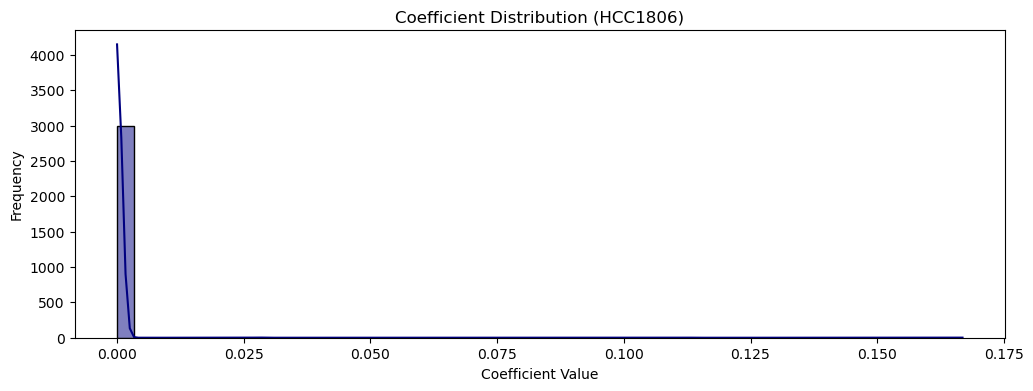

In [37]:
plt.figure(figsize=(12, 4))
sns.histplot(elastic_net.coef_.flatten(), bins=50, color='navy', kde=True)
plt.title("Coefficient Distribution (HCC1806)")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()

In [38]:
selected_genes = Xs_train.columns[selected_mask]
print("Selected genes:", selected_genes.tolist())

Selected genes: ['DDIT4', 'ANGPTL4', 'NDRG1', 'EGLN3', 'CA9', 'BNIP3', 'LDHA', 'P4HA1', 'ALDOA']


### **4.1.2.** Random Forest Importance

To capture non-linear gene–gene interactions and complement the linear Elastic Net selection, we apply a **Random Forest** classifier:

1. **Pipeline**  
   - Use `RandomForestClassifier()` (trees handle unscaled features directly).

2. **Hyperparameter tuning**  
   - Wrap the pipeline in `GridSearchCV` with 5-fold CV (scoring=`roc_auc`).  
   - Tune key parameters:  
     - **`n_estimators`** ∈ [100, 400, 600, 1000]  
     - **`max_depth`** ∈ [None, 10, 20]  
     - **`min_samples_leaf`** ∈ [1, 5]  

3. **Feature importance**  
   - Fit the best estimator on each training fold.  
   - Rank genes by `feature_importances_`.  
   - **Select the top 20 genes** per seed for downstream stability analysis.

This non-linear ranking allows us to:
- Verify which genes are important beyond the Elastic Net selection  
- Ensure that high cross-validated performance is not driven solely by linear effects  
- Provide a complementary perspective on gene relevance in the hypoxia vs. normoxia classification task  


In [39]:
param_grid = {
  'n_estimators': [100, 400, 600, 1000],
  'max_depth': [None, 10, 20],
  'min_samples_leaf': [1, 5]
}
rf = RandomForestClassifier(random_state=0)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,                    # small inner CV on the training split
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid.fit(Xs_train_log, ys_train)

print("Best RF params:", grid.best_params_)
print("CV AUC:", grid.best_score_)

rf.fit(Xs_train_log, ys_train)

# Evaluate AUC on val
ys_val_proba_rf = rf.predict_proba(Xs_val_log)[:, 1]
auc_rf = roc_auc_score(ys_val, ys_val_proba_rf)
print(f"RF ROC AUC on val (full genes): {auc_rf:.4f}")

# Compute importances only for LASSO-selected genes
importances = rf.feature_importances_
gene_names = np.array(Xs_train.columns)
top_indices = np.argsort(importances)[::-1][:20]
top_rf_genes = gene_names[top_indices]

print("Top 20 RF genes:")
for g in top_rf_genes[:20]:
    print(g)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400}
CV AUC: 0.9988344988344989
RF ROC AUC on val (full genes): 1.0000
Top 20 RF genes:
EGLN3
SLC2A1
P4HA1
CA9
BNIP3L
SLC6A8
FAM162A
ALDOA
ANGPTL4
DDIT4
FUT11
C4orf3
PLIN2
PGK1
EGLN1
BNIP3
HK2
LDHA
ALDOC
PFKFB3


### **4.1.3.** Stability Across Seeds
Embedded selection methods can be sensitive to random initialization and the particular train–validation split. To ensure our final gene signature is **robust** and **reproducible**, we repeat the Elastic Net + Random Forest pipeline over multiple random seeds.  

For each `seed`:
   - **Train–validation split**: stratified 80/20 split with `random_state=seed`.  
   - **Elastic Net**: fit the tuned model (`C=best_C`, `l1_ratio=best_l1_ratio`) on the scaled train fold → select non-zero genes.  
   - **Random Forest**: fit the tuned RF (`n_estimators`, `max_depth`, `min_samples_leaf` from grid search) on the log-transformed train fold → pick top 20 genes by `feature_importances_`.

This approach filters out genes that appear spuriously due to a particular split or random seed, enhancing reproducibility and ensuring that our downstream biological interpretations rest on a stable foundation.

In [40]:
best_C = elastic_net.C_[0]
best_l1_ratio = elastic_net.l1_ratio_[0]
rf_params = grid.best_params_
seeds = [7, 21, 42, 123, 999]

en_sets = []
rf_sets = []

for seed in seeds:
    print(f"\n Seed {seed}")

    # Stratified train/val split
    X_train, _, y_train, _ = train_test_split(
        Xs_train, ys_train, test_size=0.2,
        stratify=ys_train, random_state=seed
    )
    #Normalize
    X_train_log = np.log1p(X_train)

    # Scaling on training set only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_log)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    # Elastic Net
    en = LogisticRegression(
        penalty='elasticnet', solver='saga',
        C=best_C, l1_ratio=best_l1_ratio,
        max_iter=10000, random_state=seed, n_jobs=-1
    )
    en.fit(X_train_scaled, y_train)

    # Select non-zero genes
    selector = SelectFromModel(en, prefit=True)
    selected_en = X_train.columns[selector.get_support()]
    en_sets.append(set(selected_en))

    # RF for nonlinear ranking (Log Only)
    rf = RandomForestClassifier(
        n_estimators=rf_params['n_estimators'],
        max_depth=rf_params['max_depth'],
        min_samples_leaf=rf_params['min_samples_leaf'],
        random_state=seed, n_jobs=-1
    )
    rf.fit(X_train_log, y_train)
    importances = rf.feature_importances_
    top_rf_genes_smart = X_train.columns[np.argsort(importances)[-20:]]
    rf_sets.append(set(top_rf_genes_smart))
    print(f"Top RF genes (sample): {list(top_rf_genes_smart)[:5]}")


 Seed 7
Top RF genes (sample): ['LOXL2', 'ALDOA', 'PLOD2', 'C4orf3', 'NDRG1']

 Seed 21
Top RF genes (sample): ['BHLHE40', 'ALDOC', 'P4HA1', 'LDHA', 'PLIN2']

 Seed 42
Top RF genes (sample): ['HILPDA', 'NDRG1', 'LOXL2', 'ALDOC', 'BHLHE40']

 Seed 123
Top RF genes (sample): ['ALDOA', 'EGLN1', 'BHLHE40', 'SLC6A8', 'ERO1A']

 Seed 999
Top RF genes (sample): ['PFKFB3', 'SLC6A8', 'PLIN2', 'EGLN1', 'P4HA1']


In [41]:
en_counter_smart = Counter(g for s in en_sets for g in s)
rf_counter_smart = Counter(g for s in rf_sets for g in s)

stable_genes_smart = [g for g,c in en_counter_smart.items() if c >= 5 and rf_counter_smart[g] >= 2]
print(f"\nFinal stable genes ({len(stable_genes_smart)}):\n{stable_genes_smart}")


Final stable genes (5):
['ALDOA', 'NDRG1', 'ANGPTL4', 'CA9', 'EGLN3']


In [42]:
# Save as txt file
with open("stable_genes_hcc_smart.txt", "w") as f:
    for g in stable_genes_smart:
        f.write(g + "\n")

### **4.2.** ***DropSeq***  
This section performs feature selection on the Drop-seq dataset, which consists of the 300 pre-filtered genes and about $\sim$ 14000 cells.


### **4.2.1.** Elastic Net Logistic Regression  
After MI filtering, we
1. **Apply Elastic Net logistic regression** (embedded selection)  
2. **Tune** both the inverse‐regularization strength `C` and the elastic‐net mix `l1_ratio` via 5-fold `GridSearchCV` (scoring=`roc_auc`)  
3. **Extract** top genes  

This combination of sparsity (L₁) and grouping (L₂) penalties helps guard against noisy, correlated predictors while ensuring we capture the strongest, most reproducible signals.

In [43]:
pipe_en = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=10000,
        random_state=42
    ))
])

# 2) Define hyperparameter grid
param_grid = {
    'clf__C':        [0.0005, 0.001, 0.005, 0.01, 0.05],
    'clf__l1_ratio': [0.1, 0.5, 0.9]
}

# 3) GridSearchCV on Drop-seq training data
search = GridSearchCV(
    pipe_en,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
search.fit(Xd_train_log, yd_train)   # Xd_train: cells×300 genes, yd_train: labels

best_model = search.best_estimator_
# Extract scaled training data (pipeline includes StandardScaler)
X_scaled = best_model.named_steps['scaler'].transform(Xd_train_log)

# Get coefficient array from the LogisticRegression step
coefs = best_model.named_steps['clf'].coef_.ravel()

# Build a boolean mask of which coefficients are nonzero
selected_mask = np.abs(coefs) > 1e-8

# Subset the gene names and the data
selected_genes = list(Xd_train_log.columns[selected_mask])
X_selected = Xd_train_log.loc[:, selected_mask]

# Output results
print("Best hyperparameters:", search.best_params_)
print(f"Number of genes retained by Elastic Net: {len(selected_genes)}")
print("Shape of selected feature matrix:", X_selected.shape)
print("Selected genes:", selected_genes)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best hyperparameters: {'clf__C': 0.005, 'clf__l1_ratio': 0.1}
Number of genes retained by Elastic Net: 208
Shape of selected feature matrix: (11745, 208)
Selected genes: ['MALAT1', 'BCYRN1', 'IGFBP3', 'DDIT4', 'MT-TV', 'MIR320A', 'HSP90B1', 'NDRG1', 'MIR210HG', 'MT-TQ', 'BTBD9', 'DLX2', 'GDPGP1', 'ENO1', 'ZADH2', 'GPM6A', 'HNRNPA2B1', 'TRMT2A', 'MT-ND1', 'H2AC12', 'FGF23', 'DANT1', 'AKR1C2', 'PKMYT1', 'TMSB10', 'RPS28', 'LDHA', 'CTDP1', 'H4C5', 'GABRE', 'SCN7A', 'RPS5', 'PGAM1', 'NCL', 'RHOQP3', 'FOXP4', 'UNC13D', 'NCALD', 'EGLN3', 'LIMD2', 'SQOR', 'BNIP3', 'COMMD6', 'B4GALT1', 'GPI', 'P4HA1', 'RPL41', 'COX8A', 'PROSER1', 'PGK1', 'HEPACAM', 'AHNAK2', 'TMEM79', 'RPL35', 'SHOX', 'S100A10', 'SERF2', 'ZNF117', 'HSP90AB1', 'AIP', 'RPL12', 'CXCL8', 'TMSB4X', 'NPM1P40', 'RPL39', 'PAQR7', 'H3C2', 'HLA-DPB1', 'PDLIM4', 'HBM', 'IVL', 'SOX21-AS1', 'CHTF18', 'KCNJ3', 'BNIP3L', 'S100A11', 'HNRNPU', 'LINC01637', 'B3GAT2', 'PPP1R3G', 'WWC1'

### **4.2.2** Random Forest Validation  
To validate the informativeness of the selected genes, we train a **Random Forest classifier** on the top MI-filtered genes.

This non-linear ensemble method provides an alternative perspective on gene importance, complementary to Elastic Net.  
We extract the top genes by importance score.

This step ensures that the selected features are not only sparse but also robust across model types.


In [44]:
# Random Forest validation on selected genes
pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'clf__n_estimators':    [100, 400, 600, 1000],
    'clf__max_depth':       [None, 10, 20],
    'clf__min_samples_leaf':[1, 5]
}
search_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
search_rf.fit(Xd_train_log, yd_train)

best_rf = search_rf.best_estimator_
print("Best RF params:", search_rf.best_params_)

# Feature importances
importances = best_rf.named_steps['clf'].feature_importances_
gene_names = np.array(selected_mi_genes)
top_rf_indices = np.argsort(importances)[::-1][:20]

print("Top 20 genes by RF importance:")
for i in top_rf_indices:
    print(f"{gene_names[i]}: {importances[i]:.5f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/envs/ai_lab/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 1000}
Top 20 genes by RF importance:
NDRG1: 0.04771
AKR1C2: 0.03631
IGFBP3: 0.03478
FGF23: 0.03331
BCYRN1: 0.03170
HSP90AA1: 0.03004
AKR1C1: 0.02940
WDR43: 0.02753
HSPD1: 0.02689
LDHA: 0.02637
GPM6A: 0.02323
NCL: 0.02169
EIF3J: 0.01958
RPL41: 0.01848
MALAT1: 0.01750
HSP90AB1: 0.01719
ENO1: 0.01635
TMSB10: 0.01599
RPS28: 0.01472
P4HA1: 0.01471


### **4.2.3.** Stability Analysis Across Seeds  
To ensure robustness, we repeat Elastic Net and Random Forest selection across multiple random seeds.  

For each seed, we extract the top genes selected by each method. Then, we count how often each gene is selected across runs.  
This allows us to identify **stable genes** that consistently appear regardless of random initialization — a proxy for reliability.


In [45]:
X_train_mi_df = pd.DataFrame(Xd_train_scaled, columns=selected_mi_genes, index=Xd_train.index)

seeds = [7, 21, 42, 123, 999]
drop_en_sets = []
drop_rf_sets = []

for seed in seeds:
    # 1) Stratified split on MI-filtered features
    X_tr_mi, _, y_tr, _ = train_test_split(
        X_train_mi_df, yd_train, 
        test_size=0.2, stratify=yd_train, random_state=seed
    )
    # Corresponding log data for RF (same train indices)
    train_idx = X_tr_mi.index
    X_tr_log = Xd_train_log.loc[train_idx, selected_mi_genes]
    
    # 2) Elastic Net selection
    en = LogisticRegression(
        penalty='elasticnet', solver='saga',
        C=best_C, l1_ratio=best_l1_ratio,
        max_iter=10000, random_state=seed, n_jobs=-1
    )
    en.fit(X_tr_mi, y_tr)
    selector_en = SelectFromModel(en, threshold=1e-8, prefit=True)
    en_genes = X_tr_mi.columns[selector_en.get_support()]
    drop_en_sets.append(set(en_genes))
    
    # 3) Random Forest ranking
    rf = RandomForestClassifier(
        n_estimators=rf_params['n_estimators'],
        max_depth=rf_params['max_depth'],
        min_samples_leaf=rf_params['min_samples_leaf'],
        random_state=seed, n_jobs=-1
    )
    rf.fit(X_tr_log, y_tr)
    importances = rf.feature_importances_
    top20 = X_tr_mi.columns[np.argsort(importances)[-20:]]
    drop_rf_sets.append(set(top20))


In [46]:
en_counter = Counter(g for s in drop_en_sets for g in s)
rf_counter = Counter(g for s in drop_rf_sets for g in s)

stable_genes_drop = [
    g for g, c in en_counter.items()
    if c >= 5 and rf_counter[g] >= 2
]

print(f"Stable Drop-seq Genes ({len(stable_genes_drop)}):")
print(stable_genes_drop)

Stable Drop-seq Genes (20):
['ENO1', 'EIF3J', 'LDHA', 'P4HA1', 'WDR43', 'BCYRN1', 'GPM6A', 'FGF23', 'NCL', 'AKR1C2', 'NDRG1', 'AKR1C1', 'IGFBP3', 'HSPD1', 'RPS28', 'TMSB10', 'HSP90AA1', 'HSP90AB1', 'MALAT1', 'RPL41']


In [47]:
# Save stable genes for Drop-seq
with open("stable_genes_hcc_drop.txt", "w") as f:
    for g in stable_genes_drop:
        f.write(g + "\n")

## **5.** Biological Enrichment
---

To provide a clear biological interpretation of the selected gene set (`stable_genes_smart`), we performed a **Gene Set Over-Representation Analysis** (ORA). It tests whether our selected list of genes significantly overlaps predefined curated gene sets related to biological processes.  

We specifically focused on two distinct curated gene set resources to better interpret our results:
 - **MSigDB Hallmark**:  
    Hallmark gene sets are high-quality, curated gene signatures clearly associated with specific biological states or conditions—in this case, hypoxia (low oxygen levels).

- **Gene Ontology (GO) Biological Process (BP)**:  
    GO provides a broad, structured vocabulary describing biological processes. Using GO BP gene sets, we can more comprehensively understand the general biological processes linked with hypoxia.

We tested our selected genes against these two hypoxia-specific gene sets using the `gseapy` Python library. 

> **Note:** We’re not experts in biology, so we’ll keep this to the key takeaways without over‐interpreting.

### **5.1.** ***SmartSeq***

#### **5.1.1.** Over - Representation Analysis (ORA)

We are asking: “Of the pathways or GO terms in that gene set database, which ones contain more of my genes than you’d expect by random chance?”

In [48]:
paths = {
    "MSigDB_Hallmark": "../Data/MSigDB_Hallmark.gmt",
    "GO_BP":  "../Data/GO_BP.gmt",
}

for name, p in paths.items():
    enr = gp.enrichr(
        gene_list=stable_genes_smart,
        gene_sets=p,          # point to one local GMT file
        organism='Human',
        outdir=None,
        cutoff=0.05
    )
    df_smart = enr.results.sort_values("Adjusted P-value")
    print(f"\n=== {name} ===")
    display(df_smart[['Term','Overlap','Adjusted P-value','Genes']].head(5))


=== MSigDB_Hallmark ===


,Term,Overlap,Adjusted P-value,Genes
3,HALLMARK_GLYCOLYSIS,3/200,0.001809,ALDOA;ANGPTL4;EGLN3
4,HALLMARK_HYPOXIA,3/200,0.001809,ALDOA;ANGPTL4;NDRG1
0,HALLMARK_ADIPOGENESIS,2/200,0.029229,ALDOA;ANGPTL4
7,HALLMARK_MTORC1_SIGNALING,2/200,0.029229,ALDOA;EGLN3
1,HALLMARK_ANDROGEN_RESPONSE,1/101,0.170424,NDRG1



=== GO_BP ===


,Term,Overlap,Adjusted P-value,Genes
133,GOBP_RESPONSE_TO_OXYGEN_LEVELS,4/357,0.000117,ANGPTL4;EGLN3;NDRG1;CA9
128,GOBP_RESPONSE_TO_ABIOTIC_STIMULUS,4/1185,0.006908,ANGPTL4;EGLN3;NDRG1;CA9
34,GOBP_FRUCTOSE_1_6_BISPHOSPHATE_METABOLIC_PROCESS,1/9,0.043295,ALDOA
101,GOBP_PROTEIN_UNFOLDING,1/5,0.043295,ANGPTL4
22,GOBP_CHYLOMICRON_REMODELING,1/7,0.043295,ANGPTL4


##### Hallmark Gene Sets

- **HALLMARK_HYPOXIA (p ≈ 1.81 × 10⁻³)**  
  - **Overlap:** 3 of our 200 genes (*NDRG1, ALDOA, ANGPTL4*) are part of this hallmark set.  
  - **Interpretation:** These genes are strongly linked to the cellular response to oxygen deprivation—a key signature of hypoxia, which is the biological state we're trying to identify.

- **HALLMARK_GLYCOLYSIS (p ≈ 1.81 × 10⁻³)**  
  - **Overlap:** 3 of 200 genes (*ANGPTL4, ALDOA, EGLN3*) are included.  
  - **Takeaway:** Glycolysis is the anaerobic pathway activated under low-oxygen conditions. This enrichment underscores the metabolic reprogramming typical of hypoxic cells.

##### GO Biological Processes

- **Response to Oxygen Levels (p ≈ 1.17 × 10⁻⁴)**  
  - **Overlap:** 4 genes (*NDRG1, CA9, ANGPTL4, EGLN3*).  
  - **Why it matters:** This highly enriched term directly aligns with the hypoxia signature, confirming that your gene set is significantly involved in oxygen-level sensing and adaptation.

- **Response to Abiotic Stimulus (p ≈ 6.91 × 10⁻³)**  
  - **Overlap:** Same 4 genes as above.  
  - **Takeaway:** Reinforces that these genes are not random—they respond to harsh environmental changes like oxygen deprivation.

The enrichment landscape offers a coherent biological narrative: your selected genes (from `stable_genes_smart`) are significantly associated with **hypoxia**, **glycolysis**, and **oxygen-level responses**. Core genes such as *ALDOA, ANGPTL4, EGLN3,* and *NDRG1* appear repeatedly across pathways, reinforcing their importance in the oxygen-deprived state. This biological coherence supports the robustness and functional relevance of your identified gene set.


#### **5.1.2.** Comparison with Buffa's signature

To provide external validation, we compared our 12‐gene core list against the published Buffa signature of hypoxia.

In [49]:
# Load the BUFFA GMT file
with open("../Data/buffa_hypoxia.gmt", "r") as f:
    lines = f.readlines()

# Parse the first (and only) line: format is [name, description, gene1, gene2, ...]
buffa_line = lines[0].strip().split("\t")
buffa_genes = buffa_line[2:]  # skip 'name' and 'description'

print(f"Extracted {len(buffa_genes)} BUFFA genes.")
print(buffa_genes)  # View them

Extracted 50 BUFFA genes.
['ACOT7', 'ADM', 'AK4', 'ANKRD37', 'ANLN', 'BNIP3', 'CA9', 'CDKN3', 'CHCHD2', 'CORO1C', 'CTSV', 'DDIT4', 'ENO1', 'ESRP1', 'GAPDH', 'GPI', 'HILPDA', 'HK2', 'KIF20A', 'KIF4A', 'LDHA', 'LRRC42', 'MAD2L2', 'MAP7D1', 'MCTS1', 'MIF', 'MRGBP', 'MRPL13', 'MRPL15', 'MRPS17', 'NDRG1', 'P4HA1', 'PFKP', 'PGAM1', 'PGK1', 'PNP', 'PSMA7', 'PSRC1', 'SEC61G', 'SHCBP1', 'SLC16A1', 'SLC25A32', 'SLC2A1', 'TPI1', 'TUBA1A', 'TUBA1C', 'TUBB6', 'UTP11', 'VEGFA', 'YKT6']


In [50]:
gene_names_in_dataset = set(stable_genes_smart)

# Convert BUFFA gene list to a set
buffa_set = set(buffa_genes)

# Compute intersection with your dataset
found_genes = list(buffa_set & gene_names_in_dataset)


print(f"Overlap of {len(found_genes)} genes between our selected genes and Buffa genes:")
print(sorted(found_genes))

Overlap of 2 genes between our selected genes and Buffa genes:
['CA9', 'NDRG1']


#### **5.1.3.** Expression Patterns of Top Stable Genes
To evaluate the biological interpretability of the features selected for classification, we visualized the expression distribution of the top 6 stable genes. 

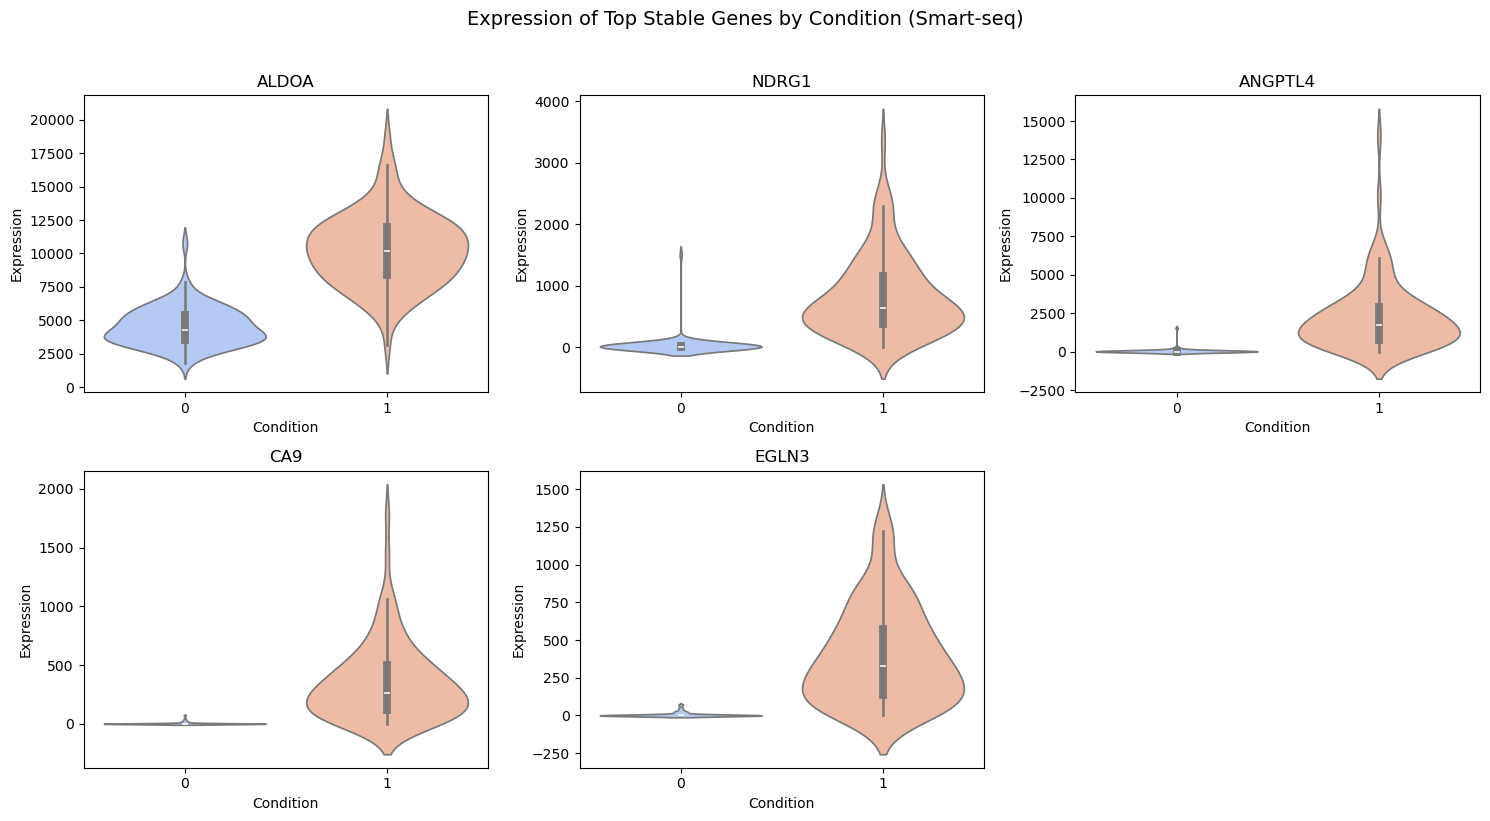

In [51]:
# Prepare merged DataFrame
Xs_vis = X_hcc_smart[stable_genes_smart].copy()
Xs_vis["Label"] = y_hcc_smart

# Choose top N genes to visualize
top_genes_smart = stable_genes_smart[:6]  # or sort by RF importance

# Plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for i, gene in enumerate(top_genes_smart):
    ax = axes.flat[i]
    sns.violinplot(x="Label", y=gene, hue="Label", data=Xs_vis, ax=ax,
                   inner="box", palette="coolwarm", legend=False)
    ax.set_title(gene)
    ax.set_xlabel("Condition")
    ax.set_ylabel("Expression")

# Remove unused subplots if any
for j in range(i + 1, len(axes.flat)):
    fig.delaxes(axes.flat[j])

fig.suptitle("Expression of Top Stable Genes by Condition (Smart-seq)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Each violin plot shows the expression of a gene across the two conditions: **Normoxia (0)** and **Hypoxia (1)**. The inner boxplot indicates the interquartile range and median.

Several genes exhibit strong differential expression between the two conditions — for instance, some genes display clear shifts in expression levels, supporting their discriminative power. This validates their inclusion in the model and highlights their potential biological relevance in hypoxia response mechanisms.

The consistency of these patterns reinforces confidence in the robustness of the supervised model and the biological validity of the selected features.

### **5.2.** ***DropSeq***

#### **5.2.1.** Over - Representation Analysis

In [52]:
paths = {
    "MSigDB_Hallmark": "../Data/MSigDB_Hallmark.gmt",
    "GO_BP":  "../Data/GO_BP.gmt",
}

for name, p in paths.items():
    enr = gp.enrichr(
        gene_list=stable_genes_drop,
        gene_sets=p,          # point to one local GMT file
        organism='Human',
        outdir=None,
        cutoff=0.05
    )
    df_drop = enr.results.sort_values("Adjusted P-value")
    print(f"\n=== {name} ===")
    display(df_drop[['Term','Overlap','Adjusted P-value','Genes']].head(5))


=== MSigDB_Hallmark ===


,Term,Overlap,Adjusted P-value,Genes
6,HALLMARK_HYPOXIA,5/200,0.001833,NDRG1;IGFBP3;P4HA1;LDHA;ENO1
5,HALLMARK_GLYCOLYSIS,4/200,0.006234,IGFBP3;LDHA;ENO1;P4HA1
9,HALLMARK_MTORC1_SIGNALING,4/200,0.006234,HSPD1;LDHA;ENO1;P4HA1
10,HALLMARK_MYC_TARGETS_V1,4/200,0.006234,HSPD1;LDHA;HSP90AB1;EIF3J
11,HALLMARK_MYC_TARGETS_V2,2/58,0.033369,HSPD1;WDR43



=== GO_BP ===


,Term,Overlap,Adjusted P-value,Genes
85,GOBP_CHAPERONE_MEDIATED_PROTEIN_COMPLEX_ASSEMBLY,3/24,0.001417,HSPD1;HSP90AB1;HSP90AA1
684,GOBP_TELOMERASE_HOLOENZYME_COMPLEX_ASSEMBLY,2/8,0.008413,HSP90AB1;HSP90AA1
324,GOBP_POLYKETIDE_METABOLIC_PROCESS,2/10,0.008413,AKR1C2;AKR1C1
10,GOBP_AMINOGLYCOSIDE_ANTIBIOTIC_METABOLIC_PROCESS,2/10,0.008413,AKR1C2;AKR1C1
430,GOBP_PROGESTERONE_METABOLIC_PROCESS,2/17,0.012649,AKR1C2;AKR1C1


The enrichment results revealed a **strong and coherent biological signal**, with the most significant terms involving **glycolysis and related metabolic pathways**, all highly relevant to cellular adaptation to hypoxia.

These results validate that the genes identified through statistical and machine learning-based selection:

- Are **biologically coherent** and not arbitrarily selected.
- Reflect **hypoxia-driven metabolic rewiring**, consistent with the cell line context.
- Overlap meaningfully with key metabolic and stress-response pathways, just like in the Smart-seq dataset.


#### **5.2.2.** Comparison with Buffa's Signature

In [53]:
gene_names_in_dataset = set(stable_genes_drop)

# Convert BUFFA gene list to a set
buffa_set = set(buffa_genes)

# Compute intersection with your dataset
found_genes = list(buffa_set & gene_names_in_dataset)

print(f"Overlap of {len(found_genes)} genes between our selected genes and Buffa genes:")
print(sorted(found_genes))

Overlap of 4 genes between our selected genes and Buffa genes:
['ENO1', 'LDHA', 'NDRG1', 'P4HA1']


#### **5.2.3.** Expression Patterns of Top Stable Genes
The violin plots below show the expression of the top 6 genes selected by the Drop-seq feature selection pipeline.

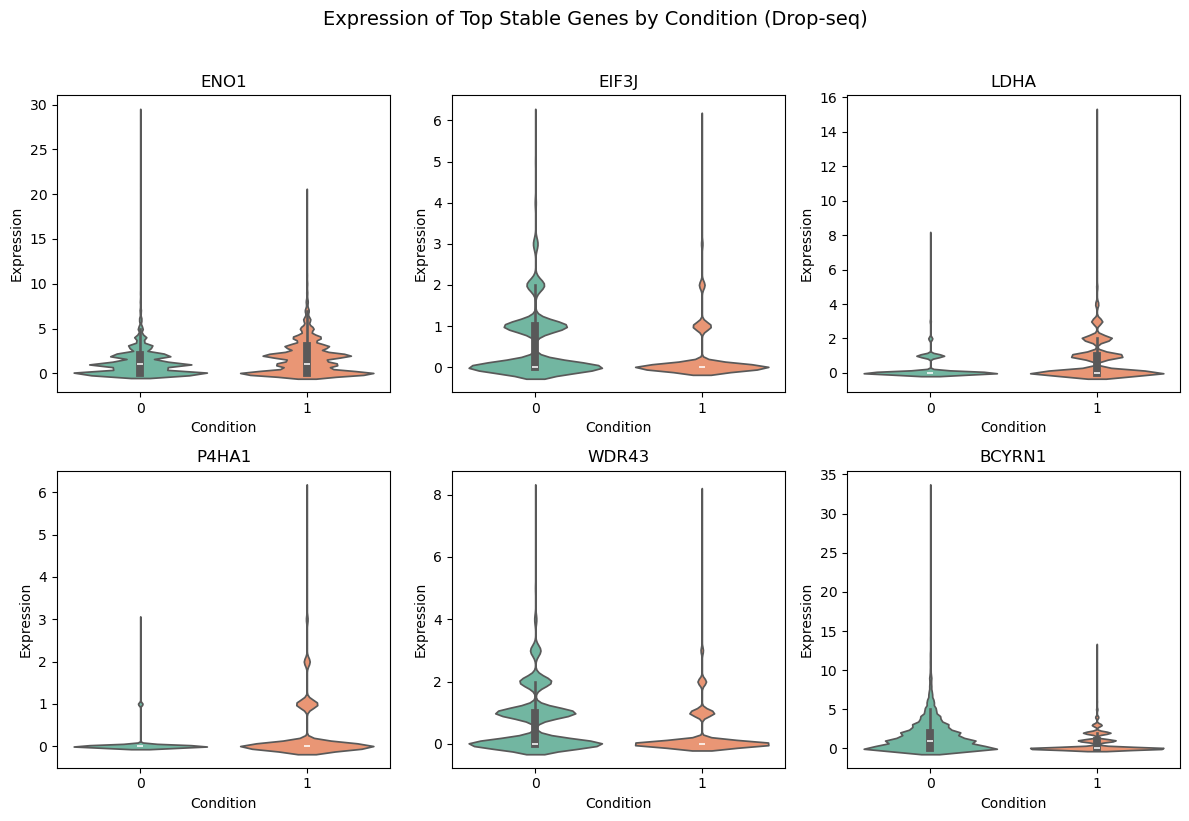

In [54]:
# Prepare merged DataFrame
Xd_vis = X_hcc_drop[stable_genes_drop].copy()
Xd_vis["Label"] = y_hcc_drop

# Choose top N genes to visualize
top_genes_drop = stable_genes_drop[:6]  # or sort by RF importance

# Plot
ncols = 3
nrows = -(-len(top_genes_drop) // ncols)  # ceiling division
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

for i, gene in enumerate(top_genes_drop):
    ax = axes.flat[i]
    sns.violinplot(x="Label", y=gene, hue="Label", data=Xd_vis,
                   ax=ax, inner="box", palette="Set2", legend=False)
    ax.set_title(gene)
    ax.set_xlabel("Condition")
    ax.set_ylabel("Expression")

# Remove any unused subplots
for j in range(i + 1, len(axes.flat)):
    fig.delaxes(axes.flat[j])

fig.suptitle("Expression of Top Stable Genes by Condition (Drop-seq)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Each violin plot visualizes the expression distribution of a top stable gene across the two conditions: **Normoxia (0)** and **Hypoxia (1)**. The shaded violins illustrate density, while the inner boxplots capture median and interquartile range.

These patterns align with the model’s feature selection and support the stability-based strategy used, highlighting genes with consistent and biologically interpretable shifts between conditions.


## **6.** Model Training and Evaluation

---

We benchmark five supervised classifiers on our final gene signature:

- **Logistic Regression**  
- **Support Vector Machine (SVM)**  
- **K‐Nearest Neighbors (KNN)**  
- **Multi‐Layer Perceptron (MLP)**  
- **XGBoost**

Each model is evaluated with **5-fold stratified cross-validation** on the training set, then assessed once on the held-out validation set.  Our evaluation criteria include:

- **ROC AUC** (discrimination capacity)  
  - ROC AUC remains valuable because it is threshold-independent and robust to class imbalance.  
- **Accuracy, Precision, Recall, F1 Score**  
  - Provide complementary views on overall correctness (Accuracy), positive-class focus (Precision), sensitivity (Recall), and their harmonic mean (F1).  
- **Confusion Matrix**  
  - Illustrates class-specific error patterns for deeper error analysis.

**Implementation details**  
- Models that are sensitive to feature scale (Logistic, SVM, KNN, MLP) are wrapped in a `Pipeline` with `StandardScaler()`.  
- Hyperparameters for each model are tuned via inner 5-fold `GridSearchCV` (scoring=`roc_auc`).  
- After cross-validation, the best hyperparameter setting is used to retrain each model on the full training set and then saved for downstream application.

This unified framework ensures a fair comparison across linear, distance-based, neural, and tree-based models, allowing us to select the classifier with the strongest and most reliable performance.  


### **6.1.** ***SmartSeq***

In [55]:

def evaluate_model(model, param_grid, X, y, name="Model", scale=False,
                   save=False, refit=True, save_path="Models_smart", cv_folds=5):

    print(f"\n Evaluating: {name}")

    # Build pipeline
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", model))
    base_pipe = Pipeline(steps)

    # Hyperparameter tuning on full CV folds
    grid = GridSearchCV(base_pipe, param_grid, cv=cv_folds,
                        scoring="roc_auc", n_jobs=-1, verbose=1, refit=True)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    print(f" Best params: {grid.best_params_}")

    # Nested CV: outer CV for metrics, inner CV for tuning
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=skf)
    y_proba = cross_val_predict(best_model, X, y, cv=skf, method='predict_proba')[:, 1]

    # Metrics
    metrics = {
        "Model": name,
        "Best Params": grid.best_params_,
        "F1 Score": f1_score(y, y_pred),
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "ROC AUC": roc_auc_score(y, y_proba),
        "Confusion Matrix": confusion_matrix(y, y_pred)
    }

    # Display results
    for k, v in metrics.items():
        if k != "Confusion Matrix":
            if isinstance(v, (float, int)):
                print(f"{k:15}: {v:.4f}")
            else:
                print(f"{k:15}: {v}")
                
    # Refit and save the model
    suffix = "HCC"
    if refit:
        best_model.fit(X, y)
        if save:
            os.makedirs(save_path, exist_ok=True)
            filename = f"{name}.{suffix}.pkl"
            filepath = Path(save_path) / filename
            with open(filepath, "wb") as f:
                pickle.dump(best_model, f)
            print(f"Model saved to {filepath}")

    return best_model, metrics

In [56]:
# Define models and whether to scale
models = {
    "Logistic": LogisticRegression(solver="saga", max_iter=5000),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
}

param_grids = {
    "Logistic": {"clf__C": [0.01, 0.1, 1, 10]},
    "SVM":      {"clf__C": [0.1, 1, 10], "clf__kernel": ["linear", "rbf"]},
    "KNN":      {"clf__n_neighbors": [3, 5, 7, 9]},
    "MLP":      {"clf__hidden_layer_sizes": [(16,), (32,), (64,)], "clf__alpha": [1e-4, 1e-3]},
    "XGBoost":  {"clf__n_estimators": [50, 100, 200], "clf__max_depth": [3, 5, 7]}
}

results_smart = []
fitted_models = {}
for name, model in models.items():
    scale = name != "XGBoost"
    best_clf, metrics = evaluate_model(
        model=model,
        param_grid=param_grids[name],
        X=Xs_train_log[stable_genes_smart],  # or final_transferable_genes
        y=ys_train,
        name=name,
        scale=scale,
        save=True,
        refit=True,
        save_path="Models_smart",
        cv_folds=5
    )
    results_smart.append(metrics)
    fitted_models[name] = best_clf

# Display summary
dfs_results = pd.DataFrame(results_smart).drop(columns=["Confusion Matrix"])
print("\n Summary of All Model Results:")
def highlight_single_best(col):
    max_idx = col.values.argmax()
    return ['background-color: #7bc800' if i == max_idx else '' for i in range(len(col))]

styled = dfs_results.style.apply(
    highlight_single_best,
    subset=["F1 Score", "Accuracy", "Precision", "Recall", "ROC AUC"],
    axis=0  # apply column-wise
)

display(styled)


 Evaluating: Logistic
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 0.01}
Model          : Logistic
Best Params    : {'clf__C': 0.01}
F1 Score       : 0.9804
Accuracy       : 0.9793
Precision      : 0.9868
Recall         : 0.9740
ROC AUC        : 0.9987
Model saved to Models_smart/Logistic.HCC.pkl

 Evaluating: SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
Model          : SVM
Best Params    : {'clf__C': 0.1, 'clf__kernel': 'linear'}
F1 Score       : 0.9804
Accuracy       : 0.9793
Precision      : 0.9868
Recall         : 0.9740
ROC AUC        : 0.9971
Model saved to Models_smart/SVM.HCC.pkl

 Evaluating: KNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__n_neighbors': 5}
Model          : KNN
Best Params    : {'clf__n_neighbors': 5}
F1 Score       : 0.9804
Accuracy       : 0.9793
Precision      : 0.9868
Recall         : 0.9740
ROC AUC        

,Model,Best Params,F1 Score,Accuracy,Precision,Recall,ROC AUC
0,Logistic,{'clf__C': 0.01},0.980392,0.979310,0.986842,0.974026,0.998663
1,SVM,"{'clf__C': 0.1, 'clf__kernel': 'linear'}",0.980392,0.979310,0.986842,0.974026,0.997135
2,KNN,{'clf__n_neighbors': 5},0.980392,0.979310,0.986842,0.974026,0.999045
3,MLP,"{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (64,)}",0.980392,0.979310,0.986842,0.974026,0.998281
4,XGBoost,"{'clf__max_depth': 3, 'clf__n_estimators': 50}",0.967320,0.965517,0.973684,0.961039,0.995416


In [57]:
print("\n\n--- Final Evaluation on Held-Out Validation Set ---")
for name, pipeline in fitted_models.items():
    print(f"\n{name}:")
    # pipeline includes scaler if needed
    X_val = Xs_val_log[stable_genes_smart]
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    print(f"F1 Score      : {f1_score(ys_val, y_pred):.4f}")
    print(f"Accuracy      : {accuracy_score(ys_val, y_pred):.4f}")
    print(f"Precision     : {precision_score(ys_val, y_pred):.4f}")
    print(f"Recall        : {recall_score(ys_val, y_pred):.4f}")
    print(f"ROC AUC       : {roc_auc_score(ys_val, y_proba):.4f}")
    print(f"Confusion Mat :\n{confusion_matrix(ys_val, y_pred)}")



--- Final Evaluation on Held-Out Validation Set ---

Logistic:
F1 Score      : 1.0000
Accuracy      : 1.0000
Precision     : 1.0000
Recall        : 1.0000
ROC AUC       : 1.0000
Confusion Mat :
[[17  0]
 [ 0 20]]

SVM:
F1 Score      : 1.0000
Accuracy      : 1.0000
Precision     : 1.0000
Recall        : 1.0000
ROC AUC       : 1.0000
Confusion Mat :
[[17  0]
 [ 0 20]]

KNN:
F1 Score      : 1.0000
Accuracy      : 1.0000
Precision     : 1.0000
Recall        : 1.0000
ROC AUC       : 1.0000
Confusion Mat :
[[17  0]
 [ 0 20]]

MLP:
F1 Score      : 1.0000
Accuracy      : 1.0000
Precision     : 1.0000
Recall        : 1.0000
ROC AUC       : 1.0000
Confusion Mat :
[[17  0]
 [ 0 20]]

XGBoost:
F1 Score      : 0.9756
Accuracy      : 0.9730
Precision     : 0.9524
Recall        : 1.0000
ROC AUC       : 0.9971
Confusion Mat :
[[16  1]
 [ 0 20]]


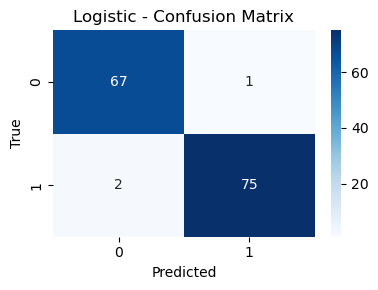

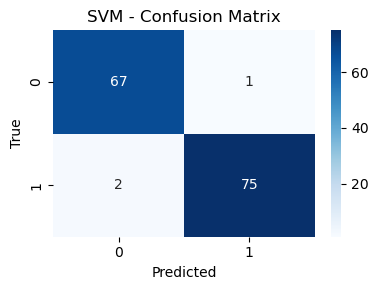

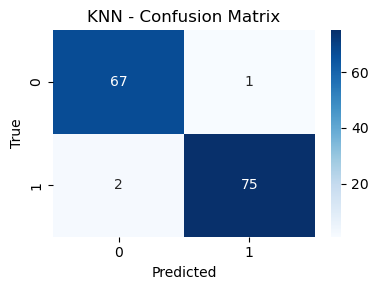

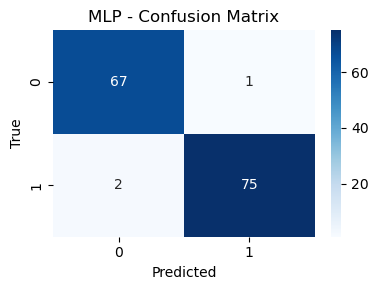

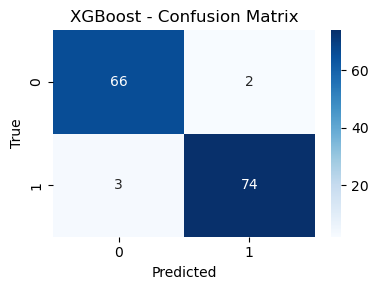

In [58]:
# Show confusion matrices after evaluation
for result in results_smart:
    cm = result["Confusion Matrix"]
    model_name = result["Model"]
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

#### - *Further Checks*
To ensure that this high accuracy did not result from overfitting or unintended data leakage, we performed two negative‐control experiments:

 - **Full Label Shuffling (Permutation Test)**:
  We permuted the training labels at random—i.e. replaced the true hypoxia/normoxia assignments with a randomly shuffled version—and reran 5-fold cross‐validation. If our model were simply memorizing idiosyncratic patterns in the features (rather than learning a genuine gene–label relationship), it would still achieve high AUC even on random labels.

In [59]:
# 1. Shuffle the labels
y_shuffled = np.random.permutation(ys_train)

# 2. Evaluate on shuffled labels (no save, no refit)
shuffled_clf, shuffled_metrics = evaluate_model(
    model=LogisticRegression(solver="saga", max_iter=5000),
    param_grid=param_grids["Logistic"],            # your Logistic grid
    X=Xs_train_log[stable_genes_smart],
    y=y_shuffled,
    name="Shuffled_Logistic",
    scale=True,
    refit=False,
    save=False,
    save_path="Models_smart",
    cv_folds=5
)


 Evaluating: Shuffled_Logistic
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 10}
Model          : Shuffled_Logistic
Best Params    : {'clf__C': 10}
F1 Score       : 0.5761
Accuracy       : 0.4621
Precision      : 0.4953
Recall         : 0.6883
ROC AUC        : 0.4450


In [60]:
def flip_labels(y, fraction=0.1, seed=42):
    np.random.seed(seed)
    y_flipped = y.copy()
    n_flip = int(len(y) * fraction)
    indices = np.random.choice(len(y), size=n_flip, replace=False)
    y_flipped[indices] = 1 - y_flipped[indices]  
    return y_flipped

# Flip 10% of ys_train
ys_train_flipped = flip_labels(ys_train, fraction=0.1)

# Evaluate performance again with flipped labels
model = LogisticRegression(max_iter=5000)

print("\nPerformance with 10% label corruption:")
clf_flipped, metrics_flipped = evaluate_model(
    model=model,
    param_grid=param_grids["Logistic"],
    X=Xs_train_log[stable_genes_smart],
    y=ys_train_flipped,
    name="Logistic_Flipped",
    scale=True,
    save=False,
    refit=False
)


Performance with 10% label corruption:

 Evaluating: Logistic_Flipped
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 0.01}
Model          : Logistic_Flipped
Best Params    : {'clf__C': 0.01}
F1 Score       : 0.8875
Accuracy       : 0.8759
Precision      : 0.8987
Recall         : 0.8765
ROC AUC        : 0.8860


In [61]:
ys_train_flipped_30 = flip_labels(ys_train, fraction=0.3)
clf30, metrics30 = evaluate_model(
    model=LogisticRegression(max_iter=5000),
    param_grid=param_grids["Logistic"],
    X=Xs_train_log[stable_genes_smart],
    y=ys_train_flipped_30,
    name="Logistic_Flipped_30",
    scale=True,
    save=False,
    refit=False
)


 Evaluating: Logistic_Flipped_30
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 1}
Model          : Logistic_Flipped_30
Best Params    : {'clf__C': 1}
F1 Score       : 0.6623
Accuracy       : 0.6414
Precision      : 0.6711
Recall         : 0.6538
ROC AUC        : 0.6374


In [62]:
del result  # avoid conflict with next loop

### **6.2.** ***DropSeq***

In [63]:

def evaluate_model_drop(model, param_grid, X, y, name="Model", scale=False,
                   save=False, refit=True, save_path="Models_drop", cv_folds=5):

    print(f"\n Evaluating: {name}")

    # Build pipeline
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", model))
    base_pipe = Pipeline(steps)

    # Hyperparameter tuning on full CV folds
    grid = GridSearchCV(base_pipe, param_grid, cv=cv_folds,
                        scoring="roc_auc", n_jobs=-1, verbose=1, refit=True)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    print(f" Best params: {grid.best_params_}")

    # Nested CV: outer CV for metrics, inner CV for tuning
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=skf)
    y_proba = cross_val_predict(best_model, X, y, cv=skf, method='predict_proba')[:, 1]

    # Metrics
    metrics = {
        "Model": name,
        "Best Params": grid.best_params_,
        "F1 Score": f1_score(y, y_pred),
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "ROC AUC": roc_auc_score(y, y_proba),
        "Confusion Matrix": confusion_matrix(y, y_pred)
    }

    # Display results
    for k, v in metrics.items():
        if k != "Confusion Matrix":
            if isinstance(v, (float, int)):
                print(f"{k:15}: {v:.4f}")
            else:
                print(f"{k:15}: {v}")
                
    # Refit and save the model
    suffix = "HCC"
    if refit:
        best_model.fit(X, y)
        if save:
            os.makedirs(save_path, exist_ok=True)
            filename = f"{name}.{suffix}.pkl"
            filepath = Path(save_path) / filename
            with open(filepath, "wb") as f:
                pickle.dump(best_model, f)
            print(f"Model saved to {filepath}")

    return best_model, metrics

In [64]:
# Define models and whether to scale
models = {
    "Logistic": LogisticRegression(solver="saga", max_iter=5000),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
}

param_grids = {
    "Logistic": {"clf__C": [0.01, 0.1, 1, 10]},
    "SVM":      {"clf__C": [0.1, 1, 10], "clf__kernel": ["linear", "rbf"]},
    "KNN":      {"clf__n_neighbors": [3, 5, 7, 9]},
    "MLP":      {"clf__hidden_layer_sizes": [(16,), (32,), (64,)], "clf__alpha": [1e-4, 1e-3]},
    "XGBoost":  {"clf__n_estimators": [50, 100, 200], "clf__max_depth": [3, 5, 7]}
}

results_drop = []
fitted_models_drop = {}
for name, model in models.items():
    scale = name != "XGBoost"
    best_clf, metrics = evaluate_model_drop(
        model=model,
        param_grid=param_grids[name],
        X=Xd_train_log[stable_genes_drop],  # or final_transferable_genes
        y=yd_train,
        name=name,
        scale=scale,
        save=True,
        refit=True,
        save_path="Models_drop",
        cv_folds=5
    )
    results_drop.append(metrics)
    fitted_models_drop[name] = best_clf

# Display summary
dfd_results = pd.DataFrame(results_drop).drop(columns=["Confusion Matrix"])
print("\n Summary of All Model Results:")

styled = dfd_results.style.apply(
    highlight_single_best,
    subset=["F1 Score", "Accuracy", "Precision", "Recall", "ROC AUC"],
    axis=0  # apply column-wise
)

display(styled)


 Evaluating: Logistic
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 1}
Model          : Logistic
Best Params    : {'clf__C': 1}
F1 Score       : 0.9087
Accuracy       : 0.8891
Precision      : 0.9074
Recall         : 0.9100
ROC AUC        : 0.9575
Model saved to Models_drop/Logistic.HCC.pkl

 Evaluating: SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params: {'clf__C': 1, 'clf__kernel': 'rbf'}
Model          : SVM
Best Params    : {'clf__C': 1, 'clf__kernel': 'rbf'}
F1 Score       : 0.9174
Accuracy       : 0.8994
Precision      : 0.9130
Recall         : 0.9218
ROC AUC        : 0.9624
Model saved to Models_drop/SVM.HCC.pkl

 Evaluating: KNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__n_neighbors': 9}
Model          : KNN
Best Params    : {'clf__n_neighbors': 9}
F1 Score       : 0.8990
Accuracy       : 0.8803
Precision      : 0.9196
Recall         : 0.8793
ROC AUC        : 0.9454
Model sav

,Model,Best Params,F1 Score,Accuracy,Precision,Recall,ROC AUC
0,Logistic,{'clf__C': 1},0.908683,0.889144,0.907410,0.909959,0.957502
1,SVM,"{'clf__C': 1, 'clf__kernel': 'rbf'}",0.917377,0.899361,0.913037,0.921759,0.962427
2,KNN,{'clf__n_neighbors': 9},0.899038,0.880289,0.919642,0.879337,0.945392
3,MLP,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (16,)}",0.912298,0.893742,0.912811,0.911785,0.960147
4,XGBoost,"{'clf__max_depth': 3, 'clf__n_estimators': 100}",0.916994,0.899191,0.915325,0.918668,0.964483


In [65]:
print("\n\n--- Final Evaluation on Held-Out Validation Set ---")
for name, pipeline in fitted_models_drop.items():
    print(f"\n{name}:")
    # pipeline includes scaler if needed
    X_val = Xd_val_log[stable_genes_drop]
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    print(f"F1 Score      : {f1_score(yd_val, y_pred):.4f}")
    print(f"Accuracy      : {accuracy_score(yd_val, y_pred):.4f}")
    print(f"Precision     : {precision_score(yd_val, y_pred):.4f}")
    print(f"Recall        : {recall_score(yd_val, y_pred):.4f}")
    print(f"ROC AUC       : {roc_auc_score(yd_val, y_proba):.4f}")
    print(f"Confusion Mat :\n{confusion_matrix(yd_val, y_pred)}")



--- Final Evaluation on Held-Out Validation Set ---

Logistic:
F1 Score      : 0.9121
Accuracy      : 0.8931
Precision     : 0.9090
Recall        : 0.9152
ROC AUC       : 0.9565
Confusion Mat :
[[ 994  163]
 [ 151 1629]]

SVM:
F1 Score      : 0.9215
Accuracy      : 0.9043
Precision     : 0.9166
Recall        : 0.9264
ROC AUC       : 0.9629
Confusion Mat :
[[1007  150]
 [ 131 1649]]

KNN:
F1 Score      : 0.9005
Accuracy      : 0.8825
Precision     : 0.9253
Recall        : 0.8770
ROC AUC       : 0.9504
Confusion Mat :
[[1031  126]
 [ 219 1561]]

MLP:
F1 Score      : 0.9176
Accuracy      : 0.9002
Precision     : 0.9189
Recall        : 0.9163
ROC AUC       : 0.9609
Confusion Mat :
[[1013  144]
 [ 149 1631]]

XGBoost:
F1 Score      : 0.9238
Accuracy      : 0.9077
Precision     : 0.9251
Recall        : 0.9225
ROC AUC       : 0.9653
Confusion Mat :
[[1024  133]
 [ 138 1642]]


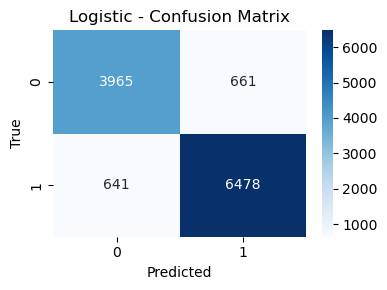

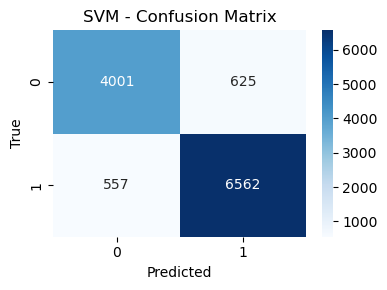

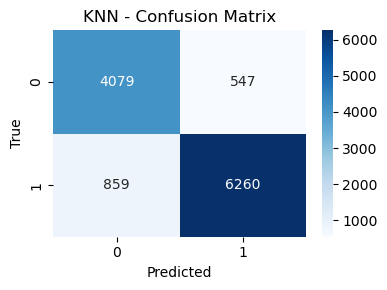

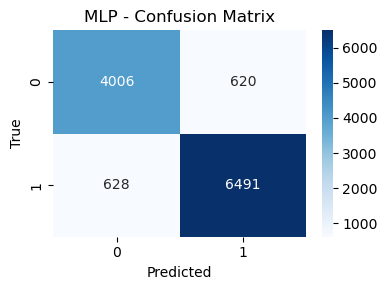

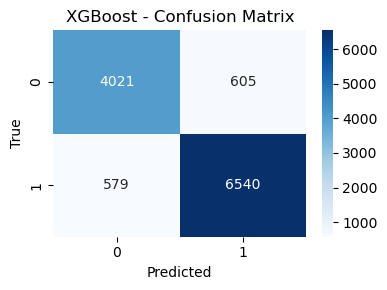

In [66]:
# Show confusion matrices after evaluation
for result in results_drop:
    cm = result["Confusion Matrix"]
    model_name = result["Model"]
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [67]:
# 1. Shuffle the labels
yd_shuffled = np.random.permutation(yd_train)

# 2. Evaluate on shuffled labels (no save, no refit)
shuffled_clf, shuffled_metrics = evaluate_model_drop(
    model=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grids["XGBoost"],            
    X=Xd_train_log[stable_genes_drop],
    y=yd_shuffled,
    name="Shuffled_XGBoost",
    scale=True,
    refit=False,
    save=False,
    save_path="Models_drop",
    cv_folds=5
)


 Evaluating: Shuffled_XGBoost
Fitting 5 folds for each of 9 candidates, totalling 45 fits
 Best params: {'clf__max_depth': 5, 'clf__n_estimators': 50}
Model          : Shuffled_XGBoost
Best Params    : {'clf__max_depth': 5, 'clf__n_estimators': 50}
F1 Score       : 0.7340
Accuracy       : 0.5941
Precision      : 0.6089
Recall         : 0.9237
ROC AUC        : 0.5115


In [68]:
# Flip 10% of yd_train
yd_train_flipped = flip_labels(yd_train, fraction=0.1)

# Evaluate performance again with flipped labels
model = XGBClassifier(eval_metric='logloss')

print("\nPerformance with 10% label corruption:")
clf_flipped, metrics_flipped = evaluate_model_drop(
    model=model,
    param_grid=param_grids["XGBoost"],
    X=Xd_train_log[stable_genes_drop],
    y=yd_train_flipped,
    name="XGB_Flipped",
    scale=True,
    save=False,
    refit=False
)


Performance with 10% label corruption:

 Evaluating: XGB_Flipped
Fitting 5 folds for each of 9 candidates, totalling 45 fits
 Best params: {'clf__max_depth': 3, 'clf__n_estimators': 50}
Model          : XGB_Flipped
Best Params    : {'clf__max_depth': 3, 'clf__n_estimators': 50}
F1 Score       : 0.8435
Accuracy       : 0.8123
Precision      : 0.8214
Recall         : 0.8669
ROC AUC        : 0.8584


In [69]:
yd_train_flipped_30 = flip_labels(yd_train, fraction=0.3)
clf30, metrics30 = evaluate_model_drop(
    model=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grids["XGBoost"],
    X=Xd_train_log[stable_genes_drop],
    y=yd_train_flipped_30,
    name="XGB_Flipped_30",
    scale=True,
    save=False,
    refit=False
)


 Evaluating: XGB_Flipped_30
Fitting 5 folds for each of 9 candidates, totalling 45 fits
 Best params: {'clf__max_depth': 3, 'clf__n_estimators': 50}
Model          : XGB_Flipped_30
Best Params    : {'clf__max_depth': 3, 'clf__n_estimators': 50}
F1 Score       : 0.6933
Accuracy       : 0.6463
Precision      : 0.6517
Recall         : 0.7405
ROC AUC        : 0.6666
